In [ ]:
%load_ext autoreload
%autoreload 2


In [3]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger

In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)




In [5]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]],
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap=swap

    def f(self, x: torch.Tensor) -> torch.Tensor:
        """f : x -> z. The inverse of g."""
        x2, x1 = self.split(x,self.swap)
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t 
        log_det = s.sum(-1) 
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        z1, z2 = self.split(z,self.swap)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        log_det = -s.sum(-1) 
        return torch.cat((x2, x1), dim=-1), log_det

In [6]:
class NormalizingFlow(nn.Module):
    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super().__init__()
        self.latent = latent
        self.flows = flows

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z                  

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=self.latent_sample(num_samples)
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward
        """Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inveres of g."""
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        x, sum_log_abs_det = z, torch.ones(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        return x, sum_log_abs_det
    

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        """Maps latent variable z to observation x
        and stores intermediate results."""
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs
    
    def __len__(self) -> int:
        return len(self.flows)

In [7]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) #???
        return [p.squeeze(-1) for p in params]
    

In [8]:
def SplitFunc(x: torch.Tensor,swap: int) -> Tuple[torch.Tensor, torch.Tensor]:
    if swap==0:
        return x[:,::2], x[:,1::2]
    else: 
        return x[:,1::2], x[:,::2] 

In [9]:
from NFconstants import N_nod
from Data import normal_dist
def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 4,  #2 to 6
                hidden_dim =100 , #100-1024
                num_params = 2)
    return theta
def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    for i in range(n_flows):
        flows.append(AffineCouplingLayer(configure_theta(),split=SplitFunc,swap=i%2))
    flows = nn.ModuleList(flows)
    return flows 
print(normal_dist)

                  

Normal(loc: torch.Size([100]), scale: torch.Size([100]))


In [10]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0.01}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs


    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    

In [27]:
from LOSS import KL_osc
from Data import train_loader

set_random_seed(42)
nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(16))
pipeline=Pipeline(model=nf,criterion=KL_osc)
trainer = pl.Trainer(
    max_epochs=2000,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights1.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 902 K 
1 | loss  | KL_with_S       | 0     
------------------------------------------
902 K     Trainable params
0         Non-trainable params
902 K     Total params
3.610     Total estimated model params size (MB)
/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


In [32]:
from LOSS import KL_osc
from Data import train_loader
nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(16))
nf.load_state_dict(torch.load('model_weights2.pth'))
pipeline=Pipeline(model=nf,criterion=KL_osc,optimizer_kwargs={"lr": 0.00001,"weight_decay": 0})
trainer = pl.Trainer(
    max_epochs=1000,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights2.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 902 K 
1 | loss  | KL_with_S       | 0     
------------------------------------------
902 K     Trainable params
0         Non-trainable params
902 K     Total params
3.610     Total estimated model params size (MB)
/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [33]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
NF_trained=NormalizingFlow(latent=normal_dist,flows=configure_flows(16))
NF_trained.load_state_dict(torch.load('model_weights2.pth'))
NF_trained.eval()
trajs=NF_trained.sample(N_traj)
trajs=trajs.numpy()
np.savetxt("nf_ensemble.txt",trajs,delimiter=",")

0.0004250635861453578
-0.000287228243845028


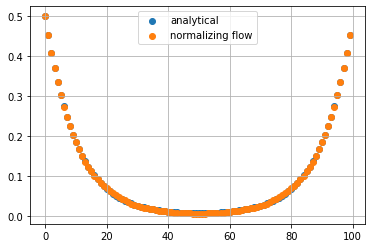

In [36]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,beta,a
from Value import G
import ensemble
from NFoscillator import basic_oscillator
from time import time
from NFandist import calc_G


ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)

g_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
g_nf=g_nf.transpose()[0]

g=calc_G(N_nod,beta,N_nod)

fig=plt.figure()
plt.scatter(list(range(NG_points)),g)
plt.scatter(list(range(NG_points)),g_nf)
#print(g_nf[0])
#print(1/(2 * a)*(1-2*(g_nf[0]-g_nf[1])/a))
print(g_nf[0]-g[0])
print(g_nf[1]-g[1])
plt.legend(["analytical","normalizing flow"])
plt.grid(True)
plt.show()



In [49]:
%reload_ext tensorboard
%tensorboard --logdir=logs/nf --port=6007

TypeError: _repr_pretty_() takes 1 positional argument but 3 were given

TypeError: _repr_pretty_() takes 1 positional argument but 3 were given